In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import datetime as dt
import math
import seaborn as sns
import miceforest as mf
from tableone import TableOne, load_dataset

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Screen patients with S-AKI according to the definition

## sepsis (sofa time > infection time)

In [ ]:
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic/disease_definition/sepsis//"
infile = data_dir + "sk_sepsis_onset.csv"
df_sepsis = pd.read_csv(infile)
df_sepsis["sofa_time"] = pd.to_datetime(df_sepsis["sofa_time"], format='%d/%m/%Y %H:%M:%S')
df_sepsis["suspected_infection_time"] = pd.to_datetime(df_sepsis["suspected_infection_time"], format='%d/%m/%Y %H:%M:%S')
df_sepsis= df_sepsis[ (df_sepsis["sofa_time"]>= df_sepsis["suspected_infection_time"]) ] 
# 
df_sepsis["sepsis_onset"] = df_sepsis["sofa_time"]

sepsis_lst = df_sepsis.stay_id.tolist()
print("The number of sepsis patients is (by sepsis3):",df_sepsis.shape[0])
df_sepsis.head(1)

## CKD

In [ ]:
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic//disease_definition/CKD/"

infile = data_dir + "sk_ckd_diagnose.csv"
df_ckd = pd.read_csv(infile)
ckd_dict = {'N183   ':"ckd3" , 'N186   ':"ESRD", '5855   ':"ckd5", '5851   ':"ckd1", 'N185   ':"ckd5", 
            '5859   ':"ckd_unknow", '5856   ':"ESRD", '5854   ':"ckd4", '5852   ':"ckd2", 'N189   ':"ckd_unknow",
            'N184   ':"ckd4", 'N182   ':"ckd2", 'N181   ':"ckd1", '5853   ':"ckd3"}
df_ckd["CKD_stage"] = df_ckd["icd_code"].map(ckd_dict)
df_ckd = df_ckd.loc[:,[ 'stay_id', 'CKD_stage']].drop_duplicates()

tmp_df = pd.DataFrame() # multiple CKD tags for stay_id
df_ckd = df_ckd.sort_values(["stay_id","CKD_stage"])
for i,j in df_ckd.groupby("stay_id"):
    j = j.iloc[:1]
    tmp_df = pd.concat([tmp_df, j], axis=0)
df_ckd = tmp_df

ckd_lst = set(df_ckd.stay_id.tolist())
print("The number of ckd patients (by ICD):",len(ckd_lst))

## AKI

In [ ]:
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic//disease_definition/AKI/"
infile = data_dir + "sk_first_and_max_stage.csv"
df_aki = pd.read_csv(infile)
df_aki = df_aki[["stay_id","first_aki_onset"]]
df_aki["first_aki_onset"] = pd.to_datetime(df_aki["first_aki_onset"])
df_aki = df_aki.rename(columns={'first_aki_onset':'AKI_onset'})

aki_lst = df_aki.stay_id.tolist()
print("The number of aki patients is (by KDIGO):",len(aki_lst))

## sepsis without CKD;  sepsis with AKI

In [5]:
sepsis_minus_ckd_lst = list(set(sepsis_lst).difference(ckd_lst))
sepsis_minusCKD_addAKI_lst = list(set(sepsis_minus_ckd_lst).intersection(aki_lst))

sepsis_noKidney_lst = list(set(sepsis_lst).difference(ckd_lst, aki_lst))
print("sepsis_minusCKD_addAKI_lst:",len(sepsis_minusCKD_addAKI_lst)," sepsis_noKidney:",len(sepsis_noKidney_lst))


sepsis_minusCKD_addAKI_lst: 12910  sepsis_noKidney: 6172


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# S-AKI inclusion criteria

## Patients who developed AKI within one week after sepsis

In [ ]:
df_sepsis = df_sepsis[df_sepsis["stay_id"].isin(sepsis_minusCKD_addAKI_lst)]
df_aki = df_aki[df_aki["stay_id"].isin(sepsis_minusCKD_addAKI_lst)]
df_sepsis_aki = pd.merge(df_sepsis, df_aki, how="left", on = ["stay_id"])

df_sepsis_aki["time_aki_minus_sepsis"] =  (df_sepsis_aki["AKI_onset"] - df_sepsis_aki["sepsis_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_sepsis_aki = df_sepsis_aki[(df_sepsis_aki["time_aki_minus_sepsis"]>0) & (df_sepsis_aki["time_aki_minus_sepsis"]<=168)]
saki_lst = df_sepsis_aki.stay_id.unique().tolist()
print("The number of patients who developed AKI within one week after sepsis:",len(saki_lst))
sns.distplot(df_sepsis_aki["time_aki_minus_sepsis"])
plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


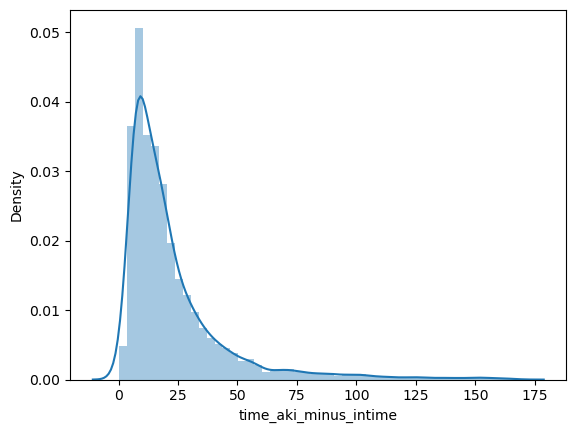

In [15]:
# df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
# df_time = df_time[df_time["stay_id"].isin(saki_lst)]
# df_time["intime"] = pd.to_datetime(df_time["intime"] )
# df_time["sepsis_onset"] = pd.to_datetime(df_time["sepsis_onset"] )
# df_time["aki_onset"] = pd.to_datetime(df_time["aki_onset"] )
# df_time["time_aki_minus_intime"] =  (df_time["aki_onset"] - df_time["intime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
# df_time["time_sepsis_minus_intime"] =  (df_time["sepsis_onset"] - df_time["intime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
# sns.distplot(df_time[df_time["time_aki_minus_intime"]<=168]["time_aki_minus_intime"])
# plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


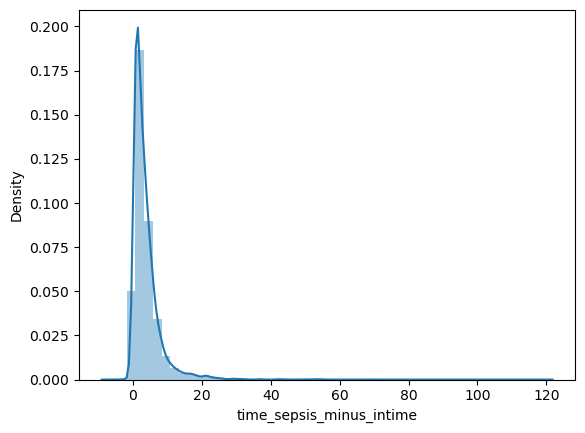

In [16]:
sns.distplot(df_time[df_time["time_sepsis_minus_intime"]<=168]["time_sepsis_minus_intime"])
plt.show()

## Excluding age<18 and los<1

In [ ]:
df_demo =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/feature_data/sk_icu_basicinfo.csv")
df_demo = df_demo.loc[:,[ 'stay_id', 'age', 'weight', 'gender', 'height',
       'race', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los',
       'dod', 'hospital_expire_flag', 'CRRT', 'apsiii', 'isckd',
       'CKD_stage', 'isaki', 'aki_stage', 'issepsis3']]
df_demo["intime"] = pd.to_datetime(df_demo["intime"], format='%d/%m/%Y %H:%M:%S')
df_demo = df_demo[df_demo["stay_id"].isin(saki_lst)]
df_demo = df_demo[ df_demo["los"]>=1] 
df_demo = df_demo[(df_demo["age"]>=18)] 

saki_lst_filt_lst = list(df_demo.stay_id.unique())
print("saki, Age >17 and los greater than 1 day:",len(saki_lst_filt_lst))
all_lst = saki_lst_filt_lst


## Patients with baseline creatinine greater than 1.5 and less than 0.5 were excluded

In [ ]:
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic/disease_definition/AKI/df_base_crea.csv")
df_base_crea = df_base_crea[(df_base_crea["baseline_cre"]>=0.5) &(df_base_crea["baseline_cre"]<1.5)]
df_base_crea = df_base_crea[df_base_crea["stay_id"].isin(all_lst)]

all_lst = df_base_crea.stay_id.unique()
print("Patients with no baseline, a baseline that is too low, or a baseline that has reached renal failure or uremia were excluded:",len(all_lst))

In [ ]:
print("Finally, the number of patients was included:",len(all_lst))

# Clinical data acquisition for clustering

In [ ]:
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/"
infile = data_dir + "sk_icu_feature.csv"
df_fea = pd.read_csv(infile)
df_fea = df_fea[df_fea["stay_id"].isin(all_lst)] 
df_fea["charttime"] = pd.to_datetime(df_fea["charttime"])

#  condition1: -4 <= time <= 28
df_cut = df_aki.loc[:,["stay_id", "AKI_onset"]]
df_cut.columns = ["stay_id", "saki_onset"] # AKI time is regarded as the occurrence time of S-AKI
df_fea_add = pd.merge(df_fea, df_cut, how="inner", on="stay_id")
df_fea_add["time"] = (df_fea_add["charttime"] - df_fea_add["saki_onset"]).map(lambda x:x/np.timedelta64(6, 'h')).tolist()
df_fea_add["time"] = df_fea_add["time"].map(lambda x:x//1) # -1 refers to the data of the first 6 hours before sepsis, and 0 refers to the data of the first 6 hours after sepsis
df_fea_add["time"] = df_fea_add["time"].map(lambda x: x+1 if x>=0 else x)
df_fea_add = df_fea_add[(df_fea_add["time"]>=-4) &(df_fea_add["time"]<=28)]

# #  condition2: There must be a record of one day or more after SAKI occurs
tmp_df = df_fea_add.groupby("stay_id").agg({"time":max}).reset_index()
stay_lst = tmp_df[tmp_df["time"]>=4]["stay_id"].tolist()
df_fea_add = df_fea_add[df_fea_add["stay_id"].isin(stay_lst)]
all_lst = df_fea_add.stay_id.unique()

#  condition3: SAKI must have at least 4 data recording points
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic/disease_definition/AKI/kdigo_stages.csv")
df_stage =df_stage[df_stage["aki_stage"]>0]
df_stage = df_stage.sort_values(["stay_id","charttime"])
df_stage = df_stage[df_stage["stay_id"].isin(all_lst)]
df_stage = df_stage.groupby("stay_id").agg({"aki_stage":"count"}).reset_index()
df_stage = df_stage[df_stage.aki_stage >=4]
all_lst = df_stage.stay_id.unique()

df_fea_add = df_fea_add[df_fea_add["stay_id"].isin(all_lst)]
all_lst = df_fea_add.stay_id.unique()
print("Patients who recorded more than one day after the occurrence of saki:", len(all_lst))
print("Finally, the number of included patients:",len(all_lst))

## Obtain data by time window


In [ ]:
df_fea_add = df_fea_add.drop(["charttime","saki_onset"],axis=1)
df_fea_add = df_fea_add.groupby(["stay_id","time"]).agg(["max","mean","min"]) 
df_fea_add.columns = ['_'.join(col) for col in df_fea_add.columns]
df_fea_add = df_fea_add.reset_index()
# A total of 260 features
#df_fea_add["time"].hist() 

## Forward interpolation

In [ ]:
# Forward interpolation
tmp_df = pd.DataFrame()
df_fea_add = df_fea_add.sort_values(by=["stay_id","time"])
for i,j in df_fea_add.groupby(["stay_id"]):
    j = j.fillna(method="ffill")
    tmp_df = pd.concat([tmp_df, j], axis=0)
df_im = tmp_df

In [ ]:
# Find according to na
df = df_im
tmp_df = pd.DataFrame(df.isna().sum()/df.shape[0])
tmp_df = tmp_df.reset_index()
fea_lst = tmp_df[tmp_df[0]<=0.6]["index"].tolist()
df_im =df_im[fea_lst]
df_im.to_csv("./df_im_By_ffill.csv",index=False)

len([i.replace("_mean","") for i in fea_lst if i.endswith("mean")]), str([i.replace("_mean","") for i in fea_lst if i.endswith("mean")])

## Multiple interpolation

In [ ]:
# Multiple interpolation
df_im = pd.read_csv("./df_im_By_ffill.csv")

kernel = mf.ImputationKernel(
    df_im,
    datasets=3,
    save_all_iterations=True,
    random_state=10
)
kernel.mice(iterations = 3, n_jobs=-1)

# After running mice, obtain the complete data set from the kernel
df_im2 = kernel.complete_data(dataset=1)
df_im2.to_csv("df_im_By_MI.csv",index=False)


## Add additional feature - Baseline creatinine rate of change

In [ ]:
# add creatinine change number is taken as the characteristic
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic//disease_definition/AKI/df_base_crea.csv")
df_feaf = pd.merge(df_im2,df_base_crea,how="inner",on="stay_id")
df_feaf["crea_divide_basecrea_max"] = round(df_feaf["creatinine_max"]/df_feaf["baseline_cre"],2)
df_feaf["crea_divide_basecrea_min"] = round(df_feaf["creatinine_min"]/df_feaf["baseline_cre"],2)
df_feaf["crea_divide_basecrea_mean"] = round(df_feaf["creatinine_mean"]/df_feaf["baseline_cre"],2)
df_feaf = df_feaf.drop(["baseline_cre"],axis=1)

## Different outputs
- Only include the average value
- Includes the maximum and minimum average values

In [ ]:
df_feaf.to_csv("sk_feature_timescale_3m.csv",index=False)
len(df_feaf.stay_id.unique())

In [ ]:
df = df_feaf.rename(columns={"stay_id":'stay_id_mean', "time":"time_mean"})
df = df.filter(regex='mean$',axis=1)
df.columns = [col.replace('_mean', '') for col in df.columns]
df.to_csv("sk_feature_timescale.csv",index=False)
len(df.stay_id.unique())

In [ ]:
# Finally, the starting point of patient clustering was determined: It was finally decided to start from 12 hours before the onset of SAKI
tmp_df = df[df["time"].isin([-4,-3,-2,-1])]
tmp_df["time"].value_counts()/len(df.stay_id.unique())


In [ ]:
df = pd.read_csv("sk_feature_timescale.csv")
df = df[df["time"]>=-2]
df.to_csv("sk_feature_timescale_Fb2.csv",index=False)

# uo, crea data in days

In [ ]:
# uo, crea data in days
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))
df_type_filt["groupHPD"].value_counts()

###
df_uo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/sk_icu_feature.csv",usecols=["stay_id","charttime","urineoutput","creatinine"])
df_uo = df_uo[df_uo["stay_id"].isin(all_lst)] 
df_uo["charttime"] = pd.to_datetime(df_uo["charttime"])
df_uo = df_uo.dropna(how='all', subset=['urineoutput',"creatinine"])

#  condition1: -4 <= time <= 28
df_time=pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_time = df_time.loc[:,["stay_id", "saki_onset"]]
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])

df_uo_add = pd.merge(df_uo, df_time, how="inner", on="stay_id")
df_uo_add["time"] = (df_uo_add["charttime"] - df_uo_add["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_uo_add["time"] = df_uo_add["time"].map(lambda x:x//1) # -1 refers to the data of the first 6 hours before sepsis, and 0 refers to the data of the first 6 hours after sepsis
df_uo_add["time"] = df_uo_add["time"].map(lambda x: x+1 if x>=0 else x)
df_uo_add = df_uo_add[(df_uo_add["time"]>=-2) &(df_uo_add["time"]<=7)]
df_uo_add = df_uo_add.drop(["charttime","saki_onset"],axis=1)
df_uo_add = df_uo_add.groupby(["stay_id","time"]).agg({"urineoutput":"mean","creatinine":"mean"}).reset_index()

df_fea  = df_uo_add
df_fea = pd.merge(df_fea,df_type_filt,how="inner",on="stay_id")
df_fea["time"] = df_fea["time"].astype("int")

In [ ]:
tmp_df = pd.DataFrame()
df_fea = df_fea.sort_values(by=["stay_id","time"])
for i,j in df_fea.groupby(["stay_id"]):
    j = j.fillna(method="ffill")
    tmp_df = pd.concat([tmp_df, j], axis=0)
df_im = tmp_df

# Multiple interpolation
kernel = mf.ImputationKernel(
    df_im,
    datasets=3,
    save_all_iterations=True,
    random_state=10
)
kernel.mice(iterations = 3, n_jobs=-1)

# After running mice, obtain the complete data set from the kernel
df_im2 = kernel.complete_data(dataset=1)
df_im2.to_csv("sk_feature_timescale_Fb2_day.csv",index=False)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Screen out kidney-related features - for subsequent clustering
Propensity matching is conducted for basic conditions and underlying diseases
1) sepsis_noKidney_lst v noCKD_AKI_before_sepsis_lst noCKD_sepsis_before_AKI_lst
2) sepsis_noKidney_lst v CKD_before_sepsis_lst 

In [ ]:
#SAKI vs sepsis_nokidney
G2_lst = list(set(all_lst).union(sepsis_noKidney_lst))
print(len(all_lst),len(sepsis_noKidney_lst),len(G2_lst))

In [4]:
# The following are two groups of kidney-related characteristics:
#1) Detection type + Detection frequency:
# bg(3h), blood_differential(1/6h), chemistry(6/12h), coagulation(2/6h),viatl (1h), complete_blood_count(1/6/12h),urine_output(1h)

## Data preparation for propensity scoring

In [ ]:
# Data Preparation for Propensity Scoring, for R
df_demo =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/feature_data/sk_icu_basicinfo.csv")
df_demo = df_demo.loc[:,['stay_id', 'age', "first_careunit",'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids',"apsiii"]]
df_demo = df_demo[df_demo["stay_id"].isin(G2_lst)]

df_demo["group_creteria"] = 2
df_demo.loc[df_demo["stay_id"].isin(sepsis_noKidney_lst),"group_creteria"] = 0 #Sepsis_nokidney
df_demo.loc[df_demo["stay_id"].isin(all_lst_filt3),"group_creteria"] = 1 #SAKI

unit_dict = {"Medical Intensive Care Unit (MICU)":1, "Cardiac Vascular Intensive Care Unit (CVICU)":2,
            "Medical/Surgical Intensive Care Unit (MICU/SICU)":3, "Surgical Intensive Care Unit (SICU)":4,
            "Trauma SICU (TSICU)":5, "Coronary Care Unit (CCU)":6,"Neuro Surgical Intensive Care Unit (Neuro SICU)":7,
            "Neuro Intermediate":7, "Neuro Stepdown":7}
#df_demo["last_careunit"] = df_demo["last_careunit"].map(unit_dict)
df_demo["first_careunit"] = df_demo["first_careunit"].map(unit_dict)

#df_demo["race"] = df_demo["race"].fillna("UNKNOWN")
#race_dict = {"WHITE":1, "UNKNOWN":2, "BLACK":3, "HISPANIC":4, "OTHER":2, "ASIAN":5, "PORTUGUESE":6, "AMERICAN_INDIAN":7, "HAWAIIAN":8, "SOUTH_AMERICAN":9,"MULTIPLE RACE":2}
#df_demo["race"] = df_demo["race"].map(race_dict)

# Interpolation weight
#tmp_df = df_demo
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer

#iterimp = IterativeImputer(random_state = 123)
#df_arr = iterimp.fit_transform(tmp_df)
#df_im = pd.DataFrame(df_arr)
#df_im.index = tmp_df.index
#df_im.columns = tmp_df.columns

#df_demo = df_im
df_demo.to_csv("sk_basicinfo_for_feaSelect.csv",index=False)

In [ ]:
lst = str(df_demo.columns.tolist())
lst = lst.replace(",","+")
lst.replace("'","")

## FDR screening features between groups

In [ ]:
import random
from scipy import stats
def iter_fea_selection(data1,data2,bg,ed):
    g1 = data1
    g2 = data2 
    tmp_lst = list(set(g1).union(set(g2)))

    data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/feature_data/"
    infile = data_dir + "sk_icu_feature.csv"
    df_fea = pd.read_csv(infile)
    df_fea["charttime"] = pd.to_datetime(df_fea["charttime"])
    df_fea = df_fea[df_fea["stay_id"].isin(tmp_lst)] 

    df_sepsis_cut = df_sepsis.loc[:,["stay_id", "sepsis_onset"]]

    df_fea_add = pd.merge(df_fea, df_sepsis_cut, how="left", on="stay_id")
    df_fea_add["interval_H"] = (df_fea_add["charttime"] - df_fea_add["sepsis_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
    df_fea_add["interval_H"] = df_fea_add["interval_H"].map(lambda x:x//1)

    df_fea_add = df_fea_add[(df_fea_add["interval_H"]>=int(bg)) & (df_fea_add["interval_H"]<=int(ed))]
    df_fea_add = df_fea_add.drop(["charttime","sepsis_onset","interval_H", "ggt",'gcs', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs_unable',"rdwsd","crp","amylase","d_dimer","thrombin", "carboxyhemoglobin", "methemoglobin","nrbc"], axis=1) #,
    df_sepsis_b12_a6= df_fea_add.groupby("stay_id").agg("mean")
    df_sepsis_b12_a6 = df_sepsis_b12_a6.reset_index()
#    print(df_sepsis_b12_a6.isna().sum()/df_sepsis_b12_a6.shape[0])

    # Obtain the p value
    df = df_sepsis_b12_a6
    group1 = df[df["stay_id"].isin(g1)]
    group2 = df[df["stay_id"].isin(g2)]

    col_lst = df.columns
    tmp_df = pd.DataFrame(columns=["feature", "p-value-real"])

    import math
    import scipy.stats as stats
    for fea in col_lst:
        group1_lst = group1[fea].tolist()
        group2_lst = group2[fea].tolist()
        group1_lst = [x for x in group1_lst if math.isnan(x) == False]
        group2_lst = [x for x in group2_lst if math.isnan(x) == False]
        p = stats.mannwhitneyu(group1_lst,group2_lst).pvalue #, use_continuity = False
        tmp_df.loc[len(tmp_df)] = [fea,p]
    return tmp_df, df_sepsis_b12_a6

In [ ]:
def FDR(x):
# Assumes a list or numpy array x which contains p-values for multiple tests, Copied from p.adjust function from R."""
    o = [i[0] for i in sorted(enumerate(x), key=lambda v:v[1],reverse=True)]
    ro = [i[0] for i in sorted(enumerate(o), key=lambda v:v[1])]
    q = sum([1.0/i for i in range(1,len(x)+1)])
    l = [q*len(x)/i*x[j] for i,j in zip(reversed(range(1,len(x)+1)),o)]
    l = [l[k] if l[k] < 1.0 else 1.0 for k in ro]
    return l


df_G = pd.read_csv("SAKI_matched.csv")
g_aki_lst = df_G[df_G["group_creteria"]==1]["stay_id"].tolist()
g_nokidney_lst = df_G[df_G["group_creteria"]==0]["stay_id"].tolist()

for i in range(0,1):
    tmp_df,Data_2group = iter_fea_selection(g_nokidney_lst, g_aki_lst, -6,18)
p = np.array(tmp_df["p-value-real"])
print("The number of original features:", len(p))
p_adj = FDR(p) # p_adjust_bh(p)
tmp_df["p_adj"] = p_adj
tmp_df_bak = tmp_df
tmp_df = tmp_df[tmp_df["p_adj"]<=0.05]

fea_lst2 = tmp_df[tmp_df["p_adj"]<=0.05]["feature"].tolist()
print("Number of significant features:", len(fea_lst2))
print("fea_lst:",str(len(fea_lst2)),fea_lst2)


In [ ]:
fea_ = ['mchc', 'lactate', 'baseexcess', 'heart_rate', 'rdw', 'mbp', 'temperature', 'bun', 'totalco2', 'platelet', 'bicarbonate', 'pt', 'pao2fio2ratio', 'aado2', 'glucose', 'creatinine', 'spo2', 'dbp', 'sodium', 'ph', 'hemoglobin', 'rbc', 'po2', 'potassium', 'wbc', 'inr', 'urineoutput', 'mcv', 'sbp', 'ptt', 'aniongap']
dis = ["linear",'beta',"beta","linear","linear","linear","linear",'beta',"linear",'beta',"linear",'beta',"linear","linear",'beta','beta','beta',"linear","linear","linear","linear","linear","linear","linear",'beta','beta',"linear","linear","linear","beta","linear"]
linear_lst = [i for i in range(len(dis)) if dis[i] == "linear"]
fea_linear = []
for i in linear_lst:
    fea_linear.append(fea_[i])
fea_beta = list(set(fea_).difference(fea_linear))

df = Data_2group
df_G = pd.read_csv("SAKI_matched.csv")
g_aki_lst = df_G[df_G["group_creteria"]==1]["stay_id"].tolist()
g_nokidney_lst = df_G[df_G["group_creteria"]==0]["stay_id"].tolist()

df.loc[df["stay_id"].isin(g_nokidney_lst),"group"] = 0
df.loc[df["stay_id"].isin(g_aki_lst),"group"] = 1

columns =  ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2', 'glucose', 'urineoutput', 'so2', 'po2', 'pco2', 'fio2', 'aado2', 'pao2fio2ratio', 'ph', 'baseexcess', 'bicarbonate', 'chloride', 'ck_mb', 'hematocrit', 'hemoglobin', 'potassium', 'sodium', 'wbc', 'free_calcium', 'calcium', 'totalco2', 'lactate', 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs', 'neutrophils_abs', 'basophils', 'eosinophils', 'lymphocytes', 'monocytes', 'neutrophils', 'atypical_lymphocytes', 'bands', 'immature_granulocytes', 'metamyelocytes', 'albumin', 'globulin', 'total_protein', 'aniongap', 'bun', 'creatinine', 'fibrinogen', 'inr', 'pt', 'ptt', 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'alt', 'alp', 'ast', 'bilirubin_total', 'bilirubin_direct', 'bilirubin_indirect', 'ck_cpk', 'ld_ldh', 'sofa']
nonnormal = list(set(columns).intersection(fea_beta))

df_fea_stat = TableOne(df, columns=columns, nonnormal=nonnormal, groupby = ["group"], pval=True)

df_fea_stat = pd.DataFrame(df_fea_stat.tableone).reset_index()
df_fea_stat = df_fea_stat.droplevel(level=0, axis=1)
df_fea_stat

#0-24h
['urineoutput', 'potassium', 'alp']

#0-48h 
['urineoutput', 'bicarbonate', 'potassium', 'alp', 'ld_ldh']

#-12-12
['resp_rate', 'spo2', 'urineoutput', 'po2', 'bicarbonate', 'potassium', 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'eosinophils', 'lymphocytes', 'monocytes', 'aniongap', 'mchc', 'platelet', 'sofa']

#-12-24
['resp_rate', 'spo2', 'urineoutput', 'po2', 'bicarbonate', 'potassium', 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'eosinophils', 'lymphocytes', 'monocytes', 'aniongap', 'mchc', 'sofa']
#-12-48
['urineoutput', 'po2', 'baseexcess', 'bicarbonate', 'potassium', 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'eosinophils', 'lymphocytes', 'monocytes', 'aniongap']

In [ ]:
fea_lst_FDR = fea_lst2

# V2 Screens out kidney-related features

In [ ]:
# Find Relevant Features (Suitable for the distribution features of the boy)
# | r | < = 0.3 there is no linear correlation, 0.3 < = | r | < = 0.5 low linear relationship, 0.5 < = | r | < = 0.8 significant linear relationship, | r | > 0.8 high linearity
infile = "./sk_feature_timescale_Fb2.csv"
df_fea = pd.read_csv(infile)

num = 0.5
df = df_fea

df_corr = df.corr(method='spearman', min_periods=1)
print(pd.DataFrame(df_corr.loc[(df_corr["creatinine"]>=num) | (df_corr["creatinine"]<=-num), "creatinine"]))
fea2_relate =  pd.DataFrame(df_corr.loc[(df_corr["creatinine"]>=num) | (df_corr["creatinine"]<=-num), "creatinine"]).index.tolist()

print("_________________")
print(pd.DataFrame(df_corr.loc[(df_corr["urineoutput"]>=num) | (df_corr["urineoutput"]<=-num), "urineoutput"]))
fea1_relate = pd.DataFrame(df_corr.loc[(df_corr["urineoutput"]>=num) | (df_corr["urineoutput"]<=-num), "urineoutput"]).index.tolist()

print("_________________")
print(pd.DataFrame(df_corr.loc[(df_corr["bun"]>=num) | (df_corr["bun"]<=-num), "bun"]))
#print("_________________")
#fea = "aniongap"
#print(pd.DataFrame(df_corr.loc[(df_corr[fea]>=num) | (df_corr[fea]<=-num), fea]))

fea_corr_lst = list(set(fea2_relate).union(set(fea1_relate)))
print(len(fea_corr_lst), fea_corr_lst)

## Output the final kidney-related features

In [ ]:
# 1h 
vital_lst = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2', 'glucose']
print("vital_lst",len(vital_lst), len(list(set(vital_lst).intersection(set(fea_lst_FDR)))))
print(list(set(vital_lst).intersection(set(fea_lst_FDR))))

# 2/6h
coagulation_lst = ['d_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt']
print("coagulation_lst",len(coagulation_lst), len(list(set(coagulation_lst).intersection(set(fea_lst_FDR)))))
print(list(set(coagulation_lst).intersection(set(fea_lst_FDR))))

# 1/6/12h
complete_blood_count_lst = ['mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw','hematocrit', 'hemoglobin', 'wbc']
print("complete_blood_count_lst", len(complete_blood_count_lst), len(list(set(complete_blood_count_lst).intersection(set(fea_lst_FDR)))))
print(list(set(complete_blood_count_lst).intersection(set(fea_lst_FDR))))

# 1h
urine_output_lst =['urineoutput']
print("urine_output_lst", len(urine_output_lst), len(list(set(urine_output_lst).intersection(set(fea_lst_FDR)))))
print(list(set(urine_output_lst).intersection(set(fea_lst_FDR))))

# 3h
blood_gas_lst =['so2', 'po2', 'pco2', 'fio2_chartevents', 'fio2', 'aado2', 'aado2_calc', 'pao2fio2ratio', 'ph', 'baseexcess', 'bicarbonate', 'carboxyhemoglobin', 'methemoglobin', 'totalco2','hematocrit', 'hemoglobin', 'chloride', 'calcium', 'temperature', 'potassium', 'sodium', 'lactate', 'glucose']
print("blood_gas_lst", len(blood_gas_lst), len(list(set(blood_gas_lst).intersection(set(fea_lst_FDR)))))
print(list(set(blood_gas_lst).intersection(set(fea_lst_FDR))))

# 
gcs_lst = ['gcs_motor', 'gcs_verbal', 'gcs_eyes' ,'gcs', 'gcs_unable']
print("gcs_lst",len(gcs_lst), len(list(set(gcs_lst).intersection(set(fea_lst_FDR)))))
print(list(set(gcs_lst).intersection(set(fea_lst_FDR))))

eny_lst = ['alt', 'alp', 'ast', 'amylase', 'bilirubin_total', 'bilirubin_direct', 'bilirubin_indirect', 'ck_cpk', 'ggt', 'ld_ldh']
print("eny_lst", len(eny_lst), len(list(set(eny_lst).intersection(set(fea_lst_FDR)))))
print(list(set(eny_lst).intersection(set(fea_lst_FDR))))

# 6/12h
chemistry_lst = ['albumin', 'globulin', 'total_protein','aniongap', 'bun', 'creatinine','potassium', 'sodium','bicarbonate', 'chloride', 'calcium']
print("chemistry_lst", len(chemistry_lst), len(list(set(chemistry_lst).intersection(set(fea_lst_FDR)))))
print(list(set(chemistry_lst).intersection(set(fea_lst_FDR))))

#1/6h
blood_differential_lst = ['basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs', 'neutrophils_abs', 'basophils', 'eosinophils', 'lymphocytes', 'monocytes', 'neutrophils', 'atypical_lymphocytes', 'bands', 'immature_granulocytes', 'metamyelocytes', 'nrbc']
print("blood_differential_lst",len(blood_differential_lst), len(list(set(blood_differential_lst).intersection(set(fea_lst_FDR)))))
print(list(set(blood_differential_lst).intersection(set(fea_lst_FDR))))

In [ ]:
del_lst = list(set(fea_lst_FDR).difference(urine_output_lst,chemistry_lst,blood_gas_lst))
fea_lst_FDR = list(set(fea_lst_FDR).difference(del_lst))
fea_lst_FDR.append("stay_id")
fea_lst_FDR.append("charttime")
print("Feature:",len(fea_lst_FDR),fea_lst_FDR)